# 02477 Exercise 2: Bayesian Linear regression

- Rev. 1.2, 1/2-23
- Rev. 1.1, 4/2-22
- Rev. 1.0, 6/2-21

### Overview

The purpose of this exercise is to become familiar with Bayesian linear regression and reinforce the basic concepts of Bayesian inference. 

The exercise is structured as follows

- Part 1: Visualize the prior, likelihood and posterior and computing the posterior and the predictive distribution for a toy example
- Part 2: Modelling the number of airline passengers and estimating hyperparameters using marginal likelihood

In [1]:
%matplotlib inline
import autograd.numpy as np
from scipy.optimize import minimize
from autograd import value_and_grad
import pylab as plt
import seaborn as snb

from scipy.stats import multivariate_normal
snb.set(font_scale=1.25)

/home/miri/anaconda3/envs/ATEL/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


Note that in this exercise, we will use the package **autograd** for automatic differentiation. You can install it using pip or your favourite package manager.

### Bayesian linear regression

Linear regression is perhaps the most common technique in applied statistics and machine learning for modelling the relationship between set of a covariates $\left\lbrace \mathbf{x}_n \right\rbrace_{n=1}^N$ and a response variable $\left\lbrace t_n \right\rbrace_{n=1}^N$. Rather than modelling the relationship between $\mathbf{x}_n$ and $t_n$ directly, we often apply a transformation $\phi$ to the input vectors $\mathbf{x}_n$ first. That is, we often use $\mathbf{\phi}_n = \mathbf{\phi}(\mathbf{x}_n)$ as input to regression model rather than $\mathbf{x}_n$ directly:

\begin{align*}
t_n = y(\phi_n, \mathbf{w}) + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n,
\end{align*}

where $y(\phi_n, \mathbf{w}) = \mathbf{\phi}_n^T \mathbf{w}$.


More generally, let $\mathbf{\Phi} \in \mathbb{R}^{N \times D}$ be a **design matrix** and let  $\mathbf{t} \in \mathbb{R}^N$ be the response variables, then the linear regression model is given by

\begin{align*}
\mathbf{t}= \mathbf{\Phi}\mathbf{w} + \mathbf{e},
\end{align*}


where $\mathbf{w} \in \mathbb{R}^D$ is the regression weights and $\mathbf{e} \in \mathbb{R}^N$ is a noise vector. In this exercise, we will only look at additive isotropic Gaussian noise models, i.e. $e_n \sim \mathcal{N}(0, \sigma^2)$, but later we will study more general set-ups. Recall, the **maximum likelihood estimate** of the weights $\mathbf{w}$ is given by

\begin{align*}
\hat{\mathbf{w}}_{\text{ML}} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{t}
\end{align*}

We will now turn to the Bayesian treatment. Assuming isotropic Gaussian noise and imposing a multivariate Gaussian prior on $\mathbf{w} \sim \mathcal{N}\left(\mathbf{m}_0, \mathbf{S}_0\right)$ gives rise to the following joint distribution

\begin{align*}
p(\mathbf{t}, \mathbf{w}) = p\left(\mathbf{t}|\mathbf{w}\right)p\left(\mathbf{w}\right) = \mathcal{N}\left(\mathbf{t}\big|\mathbf{\Phi}\mathbf{w}, \sigma^2\mathbf{I}\right)\mathcal{N}\left(\mathbf{w}\big|\mathbf{m}_0, \mathbf{S}_0\right),
\end{align*}

where $\sigma^2$ is the noise variance. We will follow Bishop's notation and use the **noise precision** $\beta = \frac{1}{\sigma^2}$ to control the noise variance.

The model is an example of a **conjugate** model, meaning that the posterior distribution will also be a Gaussian distribution given by:

\begin{align*}
p(\mathbf{w}|\mathbf{t}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S})
\end{align*}

where the posterior covariance is given by
\begin{align*}
    \mathbf{S} &= \left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\tag{1}
\end{align*}
and the posterior mean
\begin{align*}
\mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{t}.  \tag{2}
\end{align*}


First, we will look at the following a simple model:
\begin{align*}
t_n = a + bx_n +  e_n = \begin{bmatrix}1&x_n\end{bmatrix}\begin{bmatrix}a\\b\end{bmatrix} + e_n = \mathbf{\phi}_n^T \mathbf{w} + e_n.
\end{align*}

That is, $\mathbf{w} = \left[a, b\right]$, where $a$ and $b$ are the intercept and slope of the line, respectively. Furthermore, we will assume a zero-mean and isotropic Gaussian prior, i.e. $\mathbf{m}_0 = \mathbf{0}$, $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$,



### Part 1: Visualizing the prior, likelihood and posterior

We will use the following dataset with $N = 20$ data points

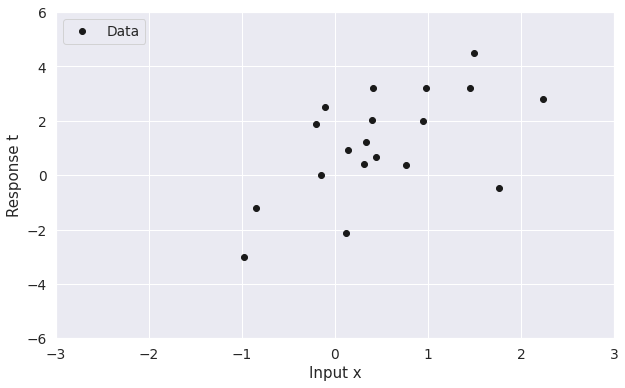

In [2]:
N = 20

xtrain = np.array([1.764, 0.4, 0.979, 2.241, 1.868, -0.977,  0.95, -0.151, -0.103, 0.411, 0.144, 1.454, 0.761, 0.122,
              0.444, 0.334, 1.494, -0.205,  0.313, -0.854])[:, None]
ttrain = np.array([-0.464, 2.024, 3.191, 2.812, 6.512, -3.022, 1.99, 0.009, 2.513, 3.194, 0.935, 3.216, 0.386, -2.118,
               0.674, 1.222, 4.481, 1.893, 0.422,  -1.209])[:, None]

# plot
plt.figure(figsize=(10, 6))
plt.plot(xtrain, ttrain, 'k.', label='Data', markersize=12)
plt.xlabel('Input x')
plt.ylabel('Response t')
plt.legend()
plt.xlim((-3, 3))
plt.ylim((-6, 6));

The purpose of this part is to understand the basic building blocks of the linear model and reinforce the concepts of prior, likelihood, and posterior. First, we will define a convenient function for evaluating and plotting distributions using densities.

In [3]:
def plot_distribution(ax, x, y, density_fun, color=None, visibility=1, label=None, title=None, num_points = 100):
    
    # create grid for parameters (a,b)
    a_array = np.linspace(-4, 4, num_points)
    b_array = np.linspace(-4, 4, num_points)
    A_array, B_array = np.meshgrid(a_array, b_array)   
    
    # form array with all combinations of (a,b) in our grid
    AB = np.column_stack((A_array.ravel(), B_array.ravel()))
    
    # evaluate density for every point in the grid and reshape bac
    Z = density_fun(x, y, A_array.ravel(), B_array.ravel())
    Z = Z.reshape((len(a_array), len(b_array)))
    
    # plot contour  
    if color is None:
        ax.contour(a_array, b_array, np.exp(Z), alpha=visibility)
    else:
        ax.contour(a_array, b_array, np.exp(Z), colors=color, alpha=visibility)
    
    if label:
        ax.plot([-1000], [-1000], color=color, label=label)
    ax.set(xlabel='slope', ylabel='intercept', xlim=(-4, 4), ylim=(-4, 4), title=title)

Then we will implement the prior, likelihood and posterior densities

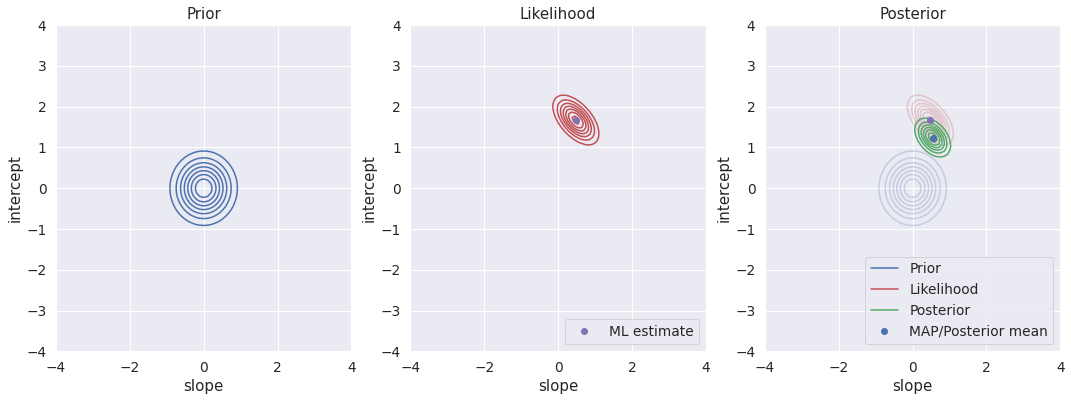

In [4]:
# hyperparameters
alpha = 5
beta = 3/4

# log normal probability density function
log_npdf = lambda x, m, v: -0.5*np.log(2*np.pi*v) -0.5*(x-m)**2/v 

# simple function for making predictions
predict = lambda x, a, b: a + b*x

def log_prior(x, t, a, b):
    return multivariate_normal.logpdf(np.column_stack([a, b]), np.array([0, 0]), 1/alpha*np.identity(2))

def log_likelihood(x, t, a, b):
    return np.sum(log_npdf(t, predict(x, a, b), 1/beta), 0)

def log_posterior(x, t, a, b):
    return log_prior(x, t, a, b) + log_likelihood(x, t, a, b)

def design_matrix(x):
    return np.column_stack((np.ones(len(x)), x))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_distribution(axes[0], xtrain, ttrain, density_fun=log_prior, color='b', title='Prior')
plot_distribution(axes[1], xtrain, ttrain, density_fun=log_likelihood, color='r', title='Likelihood')
plot_distribution(axes[2], xtrain, ttrain, density_fun=log_prior, color='b', visibility=0.25, label='Prior')
plot_distribution(axes[2], xtrain, ttrain, density_fun=log_likelihood, color='r', visibility=0.25, label='Likelihood')
plot_distribution(axes[2], xtrain, ttrain, density_fun=log_posterior, color='g', label='Posterior', title='Posterior')


##################################################################
# solution to 1.1
##################################################################

Phi_train = design_matrix(xtrain)

# compute maximum likelihoode estimate using eq. 3.15 in Bishop
w_ML = np.linalg.solve(Phi_train.T@Phi_train, Phi_train.T@ttrain).ravel()

# compute MAP/posterior mean using 3.53 in Bishop
w_MAP = (beta*np.linalg.solve(alpha*np.identity(2) + beta*(Phi_train.T@Phi_train), Phi_train.T)@ttrain).ravel()

# plot
axes[1].plot(w_ML[0], w_ML[1], 'mo', label='ML estimate')
axes[2].plot(w_ML[0], w_ML[1], 'mo')
axes[2].plot(w_MAP[0], w_MAP[1], 'bo', label='MAP/Posterior mean')

##################################################################
# end of solution to 1.1
##################################################################

axes[1].legend(loc='lower right');
axes[2].legend(loc='lower right');




***Questions:***

1.1) Plot the maximum likelihood solution, MAP solution and the posterior mean for the slope and intercept in the right-most panel above

1.2) Explain the role of $\alpha$ and $\beta$ based on the plots above. What happens if you increase or decrease $\alpha$ or $\beta$? 

1.3) What happens to the posterior mean and covariance if you let $\beta$ approach zero (this is equivalent to the noise variance going to infinity)? **Optional** Explain what you see using eq. (1) and (2) above.

**Solution to 1.3**

From eq. (1) above, we see that the posterior covariance reverts to the prior covariance when $\beta \rightarrow 0$
\begin{align*}
    \lim\limits_{\beta \rightarrow 0}\mathbf{S} =  \lim\limits_{\beta\rightarrow 0}\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1} =  \left(\mathbf{S}_0^{-1} \right)^{-1} = \mathbf{S}_0
\end{align*}
Similarly, for the posterior mean
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{t} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \beta^{-1}\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t} = \left(\beta^{-1}\mathbf{S}_0^{-1} + \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}
\end{align*}

When $\beta$ approach 0, $\beta$ increases and eventually the prior term covariance will dominate the sum in the inverse
\begin{align*}
    \mathbf{m} \approx \left(\beta^{-1}\mathbf{S}_0^{-1}\right)^{-1}\mathbf{\Phi}^T\mathbf{t} = \beta\mathbf{S}_0\mathbf{\Phi}^T\mathbf{t} \rightarrow 0
\end{align*}
Therefore, $\mathbf{m}$ converges to the zero vector as $\beta \rightarrow 0$. Since $\beta$ controls the precision of our observations, it makes intuitive sense that the model become independent of the data when the precision goes to zero (or equivalently, when the noise variance goes to infinity).



1.4) Show that when we make the prior distribution infinitely wide, i.e. $\alpha \rightarrow 0$, then the posterior mean converges to the maximum likelihood solution.


*Hints*: 
- Recall: $\mathbf{S}_0 = \alpha^{-1}\mathbf{I}$
- Substitute the expression for the posterior covariance in eq. (2) into the expression for the posterior mean  and take the limit $\alpha \rightarrow 0$.



**Solution 1.4**

Substituting eq. (1) into eq. (2) yields
\begin{align*}
    \mathbf{m} &= \beta \mathbf{S}\mathbf{\Phi}^T\mathbf{t} = \beta\left(\mathbf{S}_0^{-1} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}
\end{align*}

Next, let's substitute $\mathbf{S}_0 = \alpha^{-1} \mathbf{I}$ into the equation above to get
\begin{align*}
    \mathbf{m} = \beta\left(\alpha \mathbf{I} + \beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}
\end{align*}

Taking the limit $\alpha \rightarrow 0$ yields
\begin{align*}
    \lim\limits_{\alpha \rightarrow 0} \mathbf{m} &= \beta\left(\beta \mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}\\
    %
    &= \beta\beta^{-1}\left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}\\
    %
    &= \left(\mathbf{\Phi}^T\mathbf{\Phi}\right)^{-1}\mathbf{\Phi}^T\mathbf{t}\\
    %
    &= \hat{\mathbf{w}}_{\text{ML}}
\end{align*}

and the result follows.

In the cell below, you are given a basic implementation of Bayesian linear regression. Note that the implementation is not optimized for speed, but rather to implement the core equations as transparent as possible.

In [5]:
class BayesianLinearRegression(object):
    
    def __init__(self, Phi, y, alpha=1., beta=1.):
        
        # store data and hyperparameters
        self.Phi, self.y = Phi, y
        self.N, self.D = Phi.shape
        self.alpha, self.beta = alpha, beta
        
        # compute posterior distribution and marginal likelihood
        self.m, self.S, self.log_marginal_likelihood = self.compute_posterior(self.alpha, beta)
        
    def compute_posterior(self, alpha, beta):
        ### computes posterior N(w|m, S) and marginal likelihood ln p(t|Phi) ###
        
        # prior precision as in eq. 3.52 in Bishop
        inv_S0 = alpha*np.identity(self.D)
        
        # compute precision matrix (eq. 3.54 in Bishop)
        A = inv_S0 + beta*(self.Phi.T@self.Phi)
        
        # compute mean and covariance 
        m = beta*np.linalg.solve(A, self.Phi.T)@self.y   # (eq. 3.53 in Bishop)
        S = np.linalg.inv(A)                             # (eq. 3.54 in Bishop)
        
        # compute marginal likelihood using eq. 3.86 in Bishop
        Em = beta/2*np.sum((self.y - self.Phi@m)**2) + alpha/2*np.sum(m**2)
        log_marginal = self.D/2*np.log(alpha) + self.N/2*np.log(beta) - Em - 0.5*np.linalg.slogdet(A)[1] - self.N/2*np.log(2*np.pi)
                
        return m, S, log_marginal
        
    def predict_y(self, Phi):
        # computes posterior mean and variance of y(phi(x))
        mu_y = (Phi@self.m).squeeze()          
        var_y = np.diag(Phi@self.S@Phi.T)     
        return mu_y, var_y
        
    def predict_t(self, Phi):
        # computes predictive mean and variance of t = y(phi(x) + e using 3.58 and 3.59 in Bishop
        mu_y, var_y = self.predict_y(Phi)
        return mu_y, var_y + 1/self.beta
    
    def generate_prior_samples(self, num_samples):
        return multivariate_normal.rvs(np.zeros(len(self.m)), (1/self.alpha)*np.identity(len(self.m)), size=num_samples)
    
    def generate_posterior_samples(self, num_samples):
        return multivariate_normal.rvs(self.m.ravel(), self.S, size=num_samples)

    def optimize_hyperparameters(self):
        # optimizes hyperparameters using marginal likelihood
        theta0 = np.array((np.log(self.alpha), np.log(self.beta)))
        
        def negative_marginal_likelihood(theta):
            alpha, beta = np.exp(theta[0]), np.exp(theta[1])
            m, S, log_marginal = self.compute_posterior(alpha, beta)
            return -log_marginal

        result = minimize(value_and_grad(negative_marginal_likelihood), theta0, jac=True)

        # store new hyperparameters and recompute posterior
        theta_opt = result.x
        self.alpha, self.beta = np.exp(theta_opt[0]), np.exp(theta_opt[1])
        self.m, self.S, self.log_marginal_likelihood = self.compute_posterior(self.alpha, self.beta)
         


We will also used the following helper-functions:

In [6]:
def plot_predictions(ax, x, mu, var, color='r', visibility=0.5, label=None):
    lower, upper = mu - 1.96*np.sqrt(var), mu + 1.96*np.sqrt(var)
    ax.plot(x, mu, color=color, label=label)
    ax.plot(x, lower, color=color, linewidth=2, linestyle='--')
    ax.plot(x, upper, color=color, linewidth=2, linestyle='--')
    ax.fill_between(x.ravel(), lower.ravel(), upper.ravel(), color=color, alpha=visibility)
    ax.plot(x, mu, '-', color=color, label="", linewidth=2.5)
    

Next, we will compute and visualize the posterior distribution $p\left(\mathbf{w}|\mathbf{t}\right)$ for our toy dataset from above. After we obtained the posterior distribution $p(\mathbf{w}|\mathbf{t}) = \mathcal{N}(\mathbf{w}| \mathbf{m}, \mathbf{S})$, we can also compute the distributions of $y_* = y(\mathbf{x}_*) = \phi(x_*)^T \mathbf{w}$ and $t_* = y(\mathbf{x}_*, \mathbf{w}) + \epsilon$ for any new data point $\mathbf{x}_*$:

$$\begin{align}
p(y_*|\mathbf{t}, \mathbf{x}_*) &=  \mathcal{N}(y_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_*)\\
p(t_*|\mathbf{t}, \mathbf{x}_*) &=  \mathcal{N}(t_*|\phi_*^T\mathbf{m}, \phi_*^T\mathbf{S} \phi_* + \beta^{-1}).
\end{align}$$

We often refer to the former as the **posterior distribution of $y_*$** and to latter as the **posterior predictive distribution for $\mathbf{x}_*$**.


The cell below analyses the data set using $N = \left\lbrace 0, 1, 2, 5, 10, 20 \right\rbrace$, respectively, where the first row shows the results for $N = 0$ and so on and so forth. 


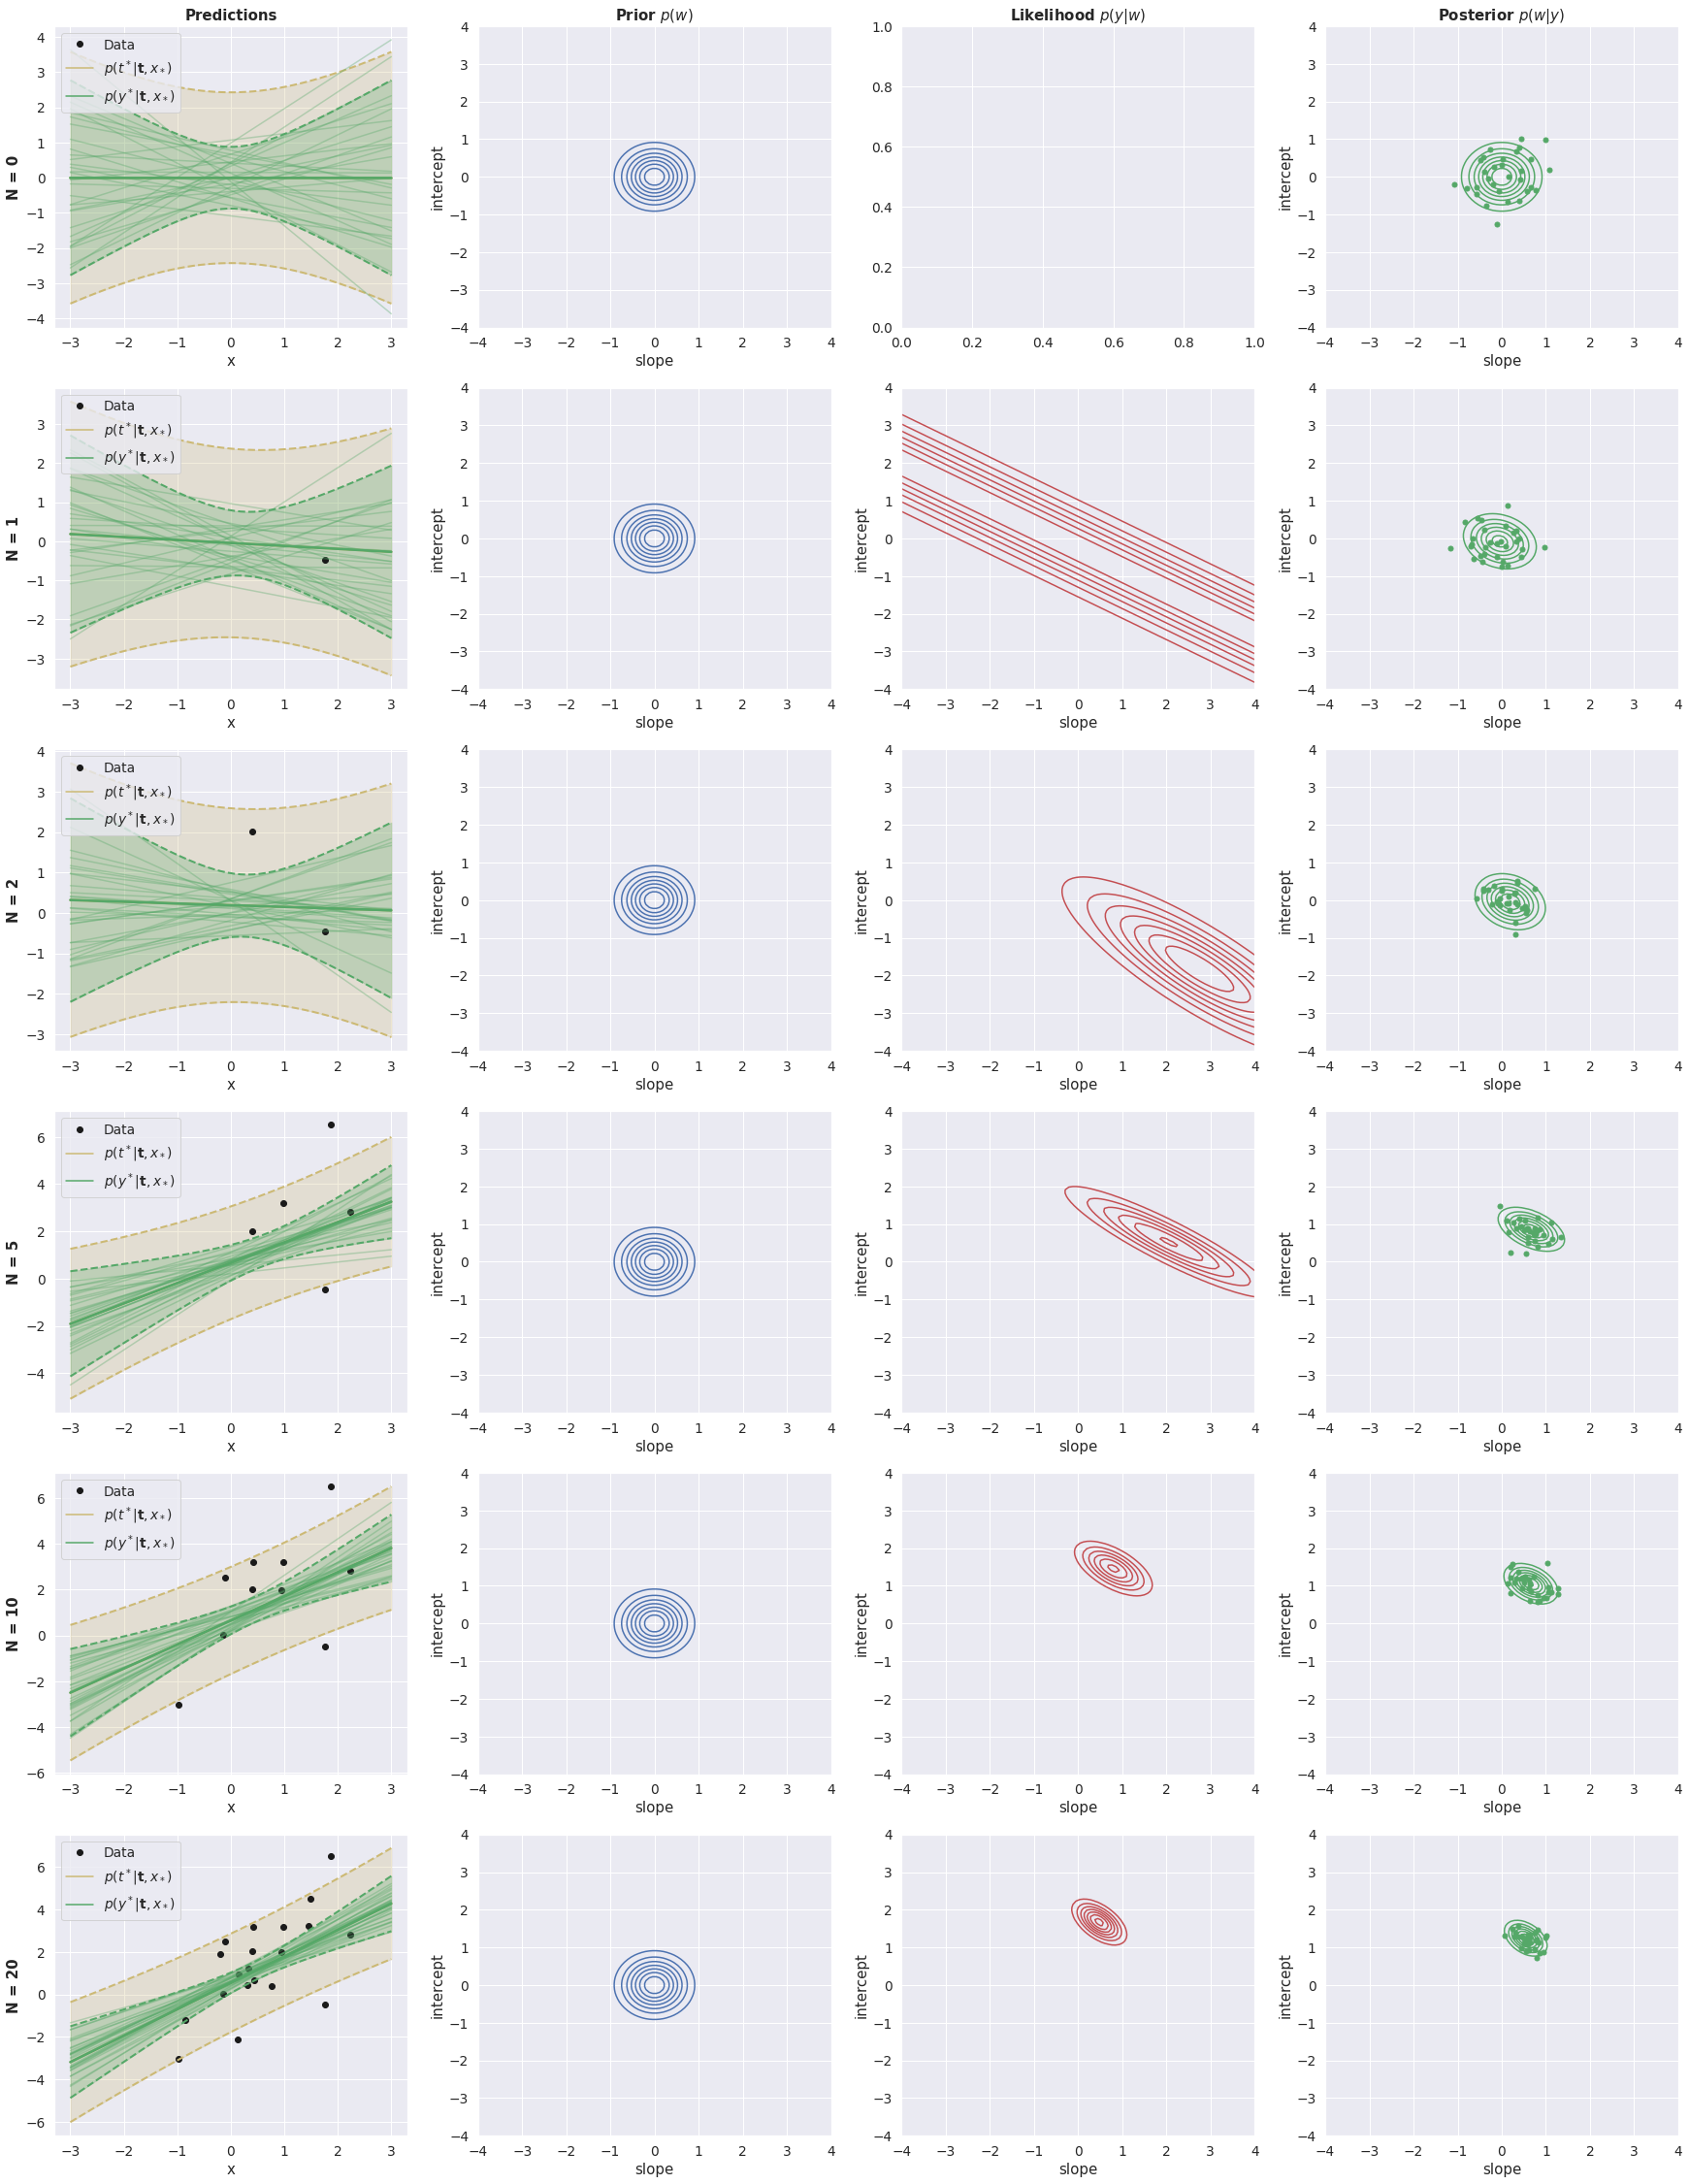

In [9]:
np.random.seed(123)

# hyperparameters
alpha = 5
beta = 3/4

# num posterior samples to plot
num_samples = 30

xpred = np.linspace(-3, 3, 50)[:, None]

# design matrices
Phi_train = design_matrix(xtrain)
Phi_pred = design_matrix(xpred)

fig, axes = plt.subplots(6, 4, figsize=(30, 40))    
for idx_n, n in enumerate([0, 1, 2, 5, 10, 20]):
    
    # compute posterior of regression weights 
    model = BayesianLinearRegression(Phi_train[:n, :], ttrain[:n, :], alpha, beta)
    w_samples = model.generate_posterior_samples(num_samples=num_samples)
    
    # split samples in a and b computes
    a_samples, b_samples = w_samples[:, 0], w_samples[:, 1]
    
    # computer posterior function values for y and t
    mu_y, var_y = model.predict_y(Phi_pred)
    mu_t, var_t = model.predict_t(Phi_pred)
    
    # plot in data space
    axes[idx_n, 0].plot(xtrain[:n, :], ttrain[:n, :], 'k.', markersize=12, label='Data')
    plot_predictions(axes[idx_n, 0], xpred, mu_t, var_t, visibility=0.25, color='y', label='$p(t^*|\mathbf{t}, x_*)$')
    plot_predictions(axes[idx_n, 0], xpred, mu_y, var_y, visibility=0.25, color='g', label='$p(y^*|\mathbf{t}, x_*)$')
    axes[idx_n, 0].set_ylabel('N = %d' % n, fontweight='bold')    
    for i, (ai, bi) in enumerate(zip(a_samples, b_samples)):
        axes[idx_n, 0].plot(xpred, predict(xpred, ai, bi), 'g-', alpha=0.35)
        
    axes[idx_n, 0].legend(loc='upper left')
    axes[idx_n, 0].set(xlabel='x')
    
    # plot prior
    plot_distribution(axes[idx_n, 1], xtrain[:n, :], ttrain[:n, :], density_fun=log_prior, color='b')
    
    # plot likelihood
    if n > 0:
        plot_distribution(axes[idx_n, 2], xtrain[:n, :], ttrain[:n, :], density_fun=log_likelihood, color='r')
        
    # plot posterior
    plot_distribution(axes[idx_n, 3], xtrain[:n, :], ttrain[:n, :], density_fun=log_posterior, color='g')
    axes[idx_n, 3].plot(a_samples, b_samples, 'g.', markersize=10)
        
    
axes[0, 0].set_title('Predictions', fontweight='bold');
axes[0, 1].set_title('Prior $p(w)$', fontweight='bold');
axes[0, 2].set_title('Likelihood $p(y|w)$', fontweight='bold');
axes[0, 3].set_title('Posterior $p(w|y)$', fontweight='bold');

In the figure above, the first column shows the data as well as the predictive distribution with 95% intervals. Each of the green lines corresponds to the function $y(x)$ for different posterior samples. The columns 2, 3, and 4 show the prior, likelihood and posterior, respectively. Study the code and the plots above and answer the following questions:

**Questions:**

1.5) How does the thin green lines in the first column relate to the green dots in the fourth column?

1.6) What happens to prior, likelihood and posterior as the number of samples $N$ increases?

1.7) The variance of the predictive distribution $p(t_*|\mathbf{t}, \mathbf{x}_*)$ contains two components. Describe the two components in your own words and relate them to epistemic and aleatoric uncertainty.

1.8) As we get more and more data, the variance of the posterior distribution of $\mathbf{w}$ goes to zero. What happens to the variance of $p(y_*|\mathbf{t}, \mathbf{x}_*)$ and $p(t_*|\mathbf{t}, \mathbf{x}_*)$ as $N$ increases?

1.9) What happens to the predictions if you keep $\beta = \frac{3}{4}$ and increase $\alpha$, e.g. to $\alpha = 100$ or $\alpha = 1000$? Why?

1.10) Set $\alpha$ to $\alpha = 1$ again. What happens if you decrease $\beta$, e.g. to $\beta = 0.1$? Why?


### Part 2: Modelling the number of Airline passengers

Now we will apply Bayesian linear regression to model the number of monthly airline passengers (in thousands) in the period from 1949-1960. The values $(x_n, t_n)$ denote the time in months since the beginning of 1949 and the number monthly number of passangers, respectively.

So far, we have assumed that the hyperparameters $\alpha$ and $\beta$ of the model were fixed and known, but in practice, we almost always need to estimate them from data (or impose a prior on them and marginalize over them). As long as the number of hyperparameters is small, we can always rely on **cross-validation**. However, often the Bayesian framework offers a way to estimate these parameters based on the training set alone as follows.

The ***evidence approximation*** suggests that we can simply choose the hyperparameters $\alpha, \beta$ that maximizes the marginal likelihood of the model

$$\begin{align}
\alpha^*, \beta^* = \arg\max\limits_{\alpha, \beta} \ln p(t|X, \alpha, \beta).
\end{align}$$

Note that since both $\alpha >0 $ and $\beta > 0$ are strictly positive parameters (why?), we optimize $\tilde{\alpha} = \log \alpha$ and $\tilde{\beta} = \log \beta$ to enforce positivity on $\alpha$ and $\beta$.
We rely on the python package **autograd** for gradient-based optimization using automatic differentiation and use the standard optimizer in scipy.


Let's load the data and plot the data.


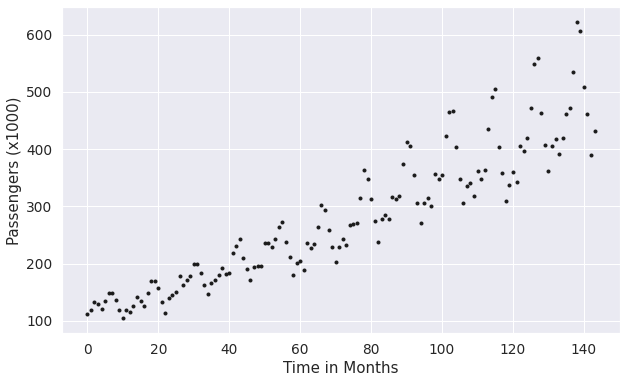

In [10]:
passengers = np.genfromtxt('./AirPassengers.csv', skip_header=1, usecols=1, delimiter=',')[:, None]
months = np.arange(0, len(passengers))[:, None]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(months, passengers, 'k.')
ax.set_xlabel('Time in Months')
ax.set_ylabel('Passengers (x1000)');

Since the number of passengers is a strictly positive quantity, we can often get better results by modelling the logarithm of the number of passengers instead.  We also split the dataset into a training and test set

N      = 144
Ntrain = 110
Ntest  = 34


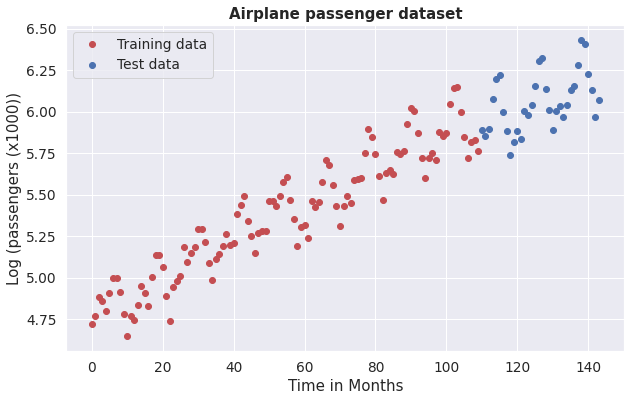

In [11]:
# log transform
t = np.log(passengers)

# split into  training and test
N = len(t)
Ntrain = 110
Ntest = N - Ntrain

x = np.arange(len(months))
xtrain = x[:Ntrain]
xtest = x[Ntrain:]

ttrain = t[:Ntrain]
ttest = t[Ntrain:]

print('N      = %d' % N)
print('Ntrain = %d' % Ntrain)
print('Ntest  = %d' % Ntest)


def plot_data(ax):
    ax.plot(xtrain, ttrain, 'ro', label='Training data')
    ax.plot(xtest, ttest, 'bo', label='Test data')
    ax.set_xlabel('Time in Months')
    ax.set_ylabel('Log (passengers (x1000))');
    ax.legend()
    ax.set_title('Airplane passenger dataset', fontweight='bold')

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_data(ax)
    



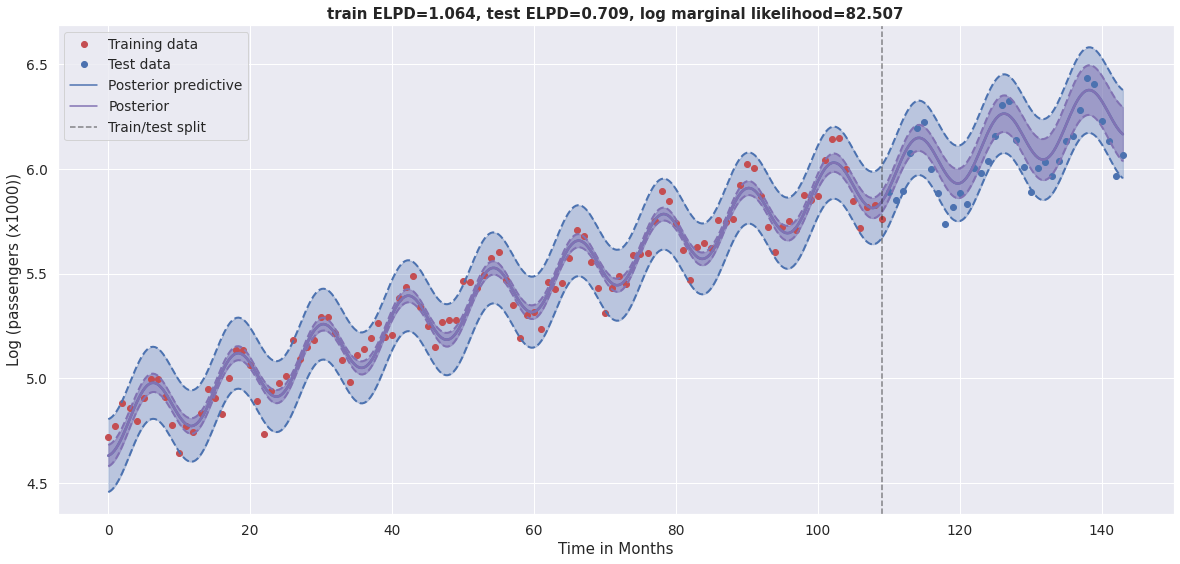

In [15]:
# we use the expected log predictive distribution as performance metric
def compute_elpd(y, mu, s2):
    return np.mean(log_npdf(y.ravel(), mu.ravel(), s2.ravel()))

# Creates design matrix Phi based on input
def design_matrix(x):
    #return np.column_stack((np.ones(len(x)), x,   ))
    #return np.column_stack((np.ones(len(x)), x, x**2))
    return np.column_stack((np.ones(len(x)), x,   x**2, np.cos(2*np.pi*x/12)))

# prepare input data
xpred = np.linspace(0, 143, 500)
Phi_train = design_matrix(xtrain)
Phi_test = design_matrix(xtest)
Phi_pred = design_matrix(xpred)

# fit model
model = BayesianLinearRegression(Phi_train, ttrain, alpha=1, beta=1)
model.optimize_hyperparameters()
logZ = model.log_marginal_likelihood

# make predictions for plotting
ypred_mu, ypred_s2 = model.predict_y(Phi_pred)
tpred_mu, tpred_s2 = model.predict_t(Phi_pred)

# make predictions for training and test set & evaluate performance metrics
ttrain_mu, ttrain_s2 = model.predict_t(Phi_train)
ttest_mu, ttest_s2 = model.predict_t(Phi_test)
train_elpd = compute_elpd(ttrain, ttrain_mu, ttrain_s2)
test_elpd = compute_elpd(ttest, ttest_mu, ttest_s2)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20,9))
plot_data(ax)
plot_predictions(ax, xpred, tpred_mu, tpred_s2, color='b', label='Posterior predictive', visibility=0.3)
plot_predictions(ax, xpred, ypred_mu, ypred_s2, color='m', label='Posterior')
ax.set_title('train ELPD=%4.3f, test ELPD=%4.3f, log marginal likelihood=%4.3f' % (train_elpd, test_elpd, logZ), fontweight='bold');
ax.axvline(xtrain[-1], color='k', linestyle='--', alpha=0.5, label='Train/test split')
ax.legend()

To measure the quality of the fit, we rely on the  **expected log predictive densities (ELPD)** for the training and test sets

\begin{align}
\text{ELPD} = \frac{1}{M}\sum_{i=1}^M \ln p(t^*_i|\mathbf{t}, \mathbf{x}^*_i),
\end{align}

where $p(t^*_i|\mathbf{t}, \mathbf{x}^*_i)$ is the predictive distribution for observation $t^*_i$ in some dataset $\mathcal{D}_* = \left\lbrace \mathbf{x}^*_i, t^*_i \right\rbrace_{i=1}^M$. In contrast to simply reporting the mean square errors or similar, the ELPD also takes the uncertainty into account.

**Questions**

2.1) Run the code with $\alpha = 10$ and $\beta = 1$ as initial values. Comment on the quality of the fit. Note the values of the negative log likelihood for the training and test set.

2.2) Estimate $\alpha, \beta$ by optimizing the marginal likelihood by uncommenting the line, which calls the function *optimize_hyperparameters()*. 

2.3) Experiment with different linear models but the uncommenting different lines in the *design_matrix()* function. Comment on the train/test ELPDs as well as the marginal likelihood.

2.4) Comment on uncertainty estimates for the training and test set.

2.5) Compute and visualize the posterior and the posterior predictive distribution for the logarithm of the number of customers after 145 months?

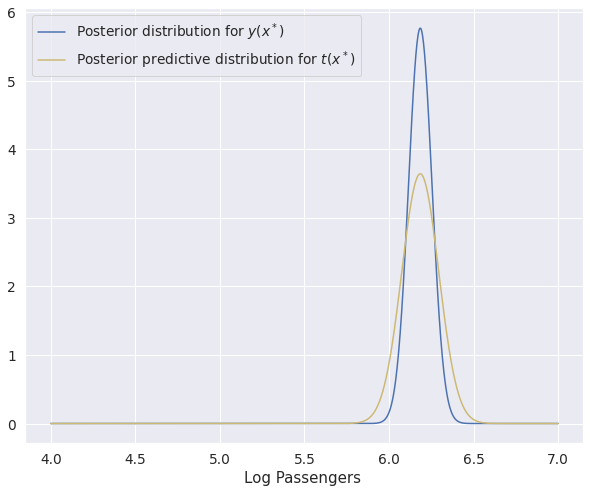

In [124]:
### solution 3.5
xstar = 145
Phi_star = design_matrix(np.array([xstar]))

ystar_mu, ystar_s2 = model.predict_y(Phi_star)
tstar_mu, tstar_s2 = model.predict_t(Phi_star)

ys = np.linspace(4, 7, 1000)
ts = np.linspace(4, 7, 1000)

npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(ys, npdf(ys, ystar_mu, ystar_s2), label='Posterior distribution for $y(x^*)$', color='b')
ax.plot(ys, npdf(ys, tstar_mu, tstar_s2), label='Posterior predictive distribution for $t(x^*)$', color='y')
ax.legend(loc='upper left')
ax.set(xlabel='Log Passengers ');


2.6) If you get hired by an airline company, and they asked you to provide a 95% credibility interval for the number of log passengers after 145, would you use the posterior distribution $p(y_*|t, x_*)$ or the posterior predictive distribution $p(t_*|t, x_*)$? and why?

2.7) **Optional** Compute the predictive distribution for the number of passengers instead of the logarithm of the number of passengers. 

- Hints: You can either using sampling techniques or you use the fact that exponentiating a Gaussian random variable is a Log-Normal distribution with closed-form moments. See more here: [https://en.wikipedia.org/wiki/Log-normal_distribution](https://en.wikipedia.org/wiki/Log-normal_distribution)

**Solution**

Let $t(x)$ denote the logarithm  of the number of passengers after x months and let $t(x)|\mathbf{t} \sim N(m, v)$ denote the predictive distribution for $t(x)$, then the number of passengers $P(x)$ is then given by 

$$\begin{align}
P(x) = \exp[t(x)]
\end{align}$$

Now because $\log P(x) \sim N(m, v)$, $P(x)$ is said to follow a log-normal distribution (https://en.wikipedia.org/wiki/Log-normal_distribution). 

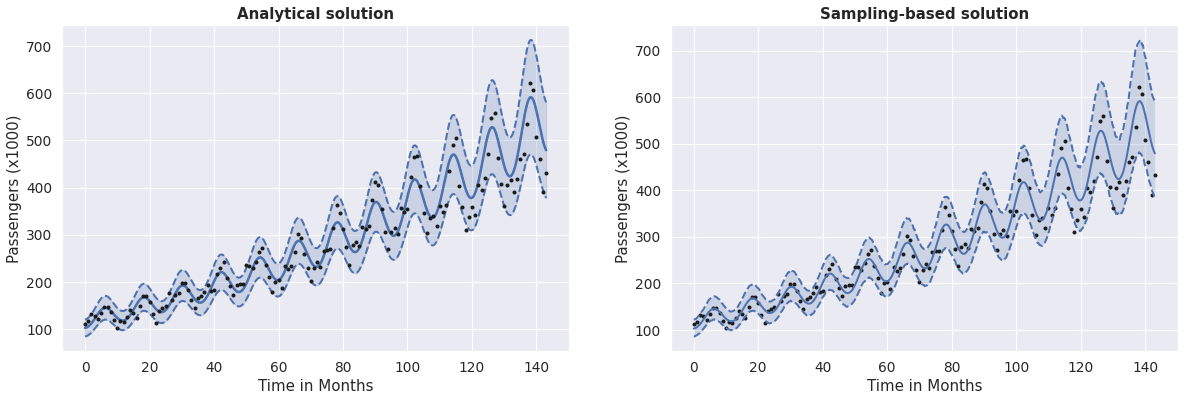

In [125]:
### solution for 2.7

# prepare data and predict mean and variance for t(x)
tpred_mu, tpred_s2 = model.predict_t(Phi_pred)

################################################
# Analytical solution via log-normal 
################################################
# compute mean and variance of exp(t(x))
lognormal_mean = lambda m, v: np.exp(m + 0.5*v)
lognormal_var = lambda m, v: (np.exp(v) - 1)*np.exp(2*m + v)
exp_t_mu = lognormal_mean(tpred_mu.ravel(), tpred_s2.ravel()) 
exp_t_s2 = lognormal_var(tpred_mu.ravel(), tpred_s2.ravel()) 


################################################
# Sampling-based solution
################################################

# generate samples from posterior predictive distribution for t
num_samples = 5000
t_samples = np.random.normal(tpred_mu, np.sqrt(tpred_s2), size=(num_samples, len(tpred_mu)))

# transform all samples by exponentialing
exp_t_samples = np.exp(t_samples)

# estimatepercentiles
lower = np.percentile(exp_t_samples, 2.5, axis=0)
upper = np.percentile(exp_t_samples, 97.5, axis=0)



# plot analytical solution
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_predictions(ax[0], xpred, exp_t_mu, exp_t_s2, color='b', visibility=0.2)
ax[0].plot(months, passengers, 'k.')
ax[0].set_xlabel('Time in Months')
ax[0].set_ylabel('Passengers (x1000)')
ax[0].set_title('Analytical solution', fontweight='bold')


# plot sampling-based solution
ax[1].plot(months, passengers, 'k.')
ax[1].fill_between(xpred, lower, upper, alpha=0.2)
ax[1].plot(xpred, exp_t_mu, 'b-', linewidth=2)
ax[1].plot(xpred, lower, 'b--', xpred, upper, 'b--', linewidth=2)
ax[1].set_xlabel('Time in Months')
ax[1].set_ylabel('Passengers (x1000)')
ax[1].set_title('Sampling-based solution', fontweight='bold');
